In [1]:
import os
import sys
import xarray
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import skimage as ski
from image_handling.imagej_manager import ImageJManager
from analysis_class import ImageProcessor
from image_handler_class import ImageAlignmentAndTifConversion
from key_class import Key

ij = ImageJManager('default').get_ij()

Failed to guess the Java version.


Registered segmentation method: cellpose
Registered segmentation method: unknown
Registered segmentation method: other


In [2]:
key = Key(r'E:\Patrick\Keys\Infection_20250214.csv', ['date', None, None, None, 'well'], skip_validation=True)


aligning_class = ImageAlignmentAndTifConversion(ij=ij,  observation_methods=2, initialized_key=key, 
                                                tracker_name=r"E:\Patrick\tracking_jsons\infection_tracker1.json")

aligning_class.process_images(r'E:\Patrick\Infection\New_parameters\Infection_20250214', save_dir=r'E:\Patrick\Infection\New_parameters\20250214_infection_save\Tif\\')

2025-03-14 02:09:51,344 - INFO - Tracker data saved.
2025-03-14 02:09:51,345 - INFO - Tracker has been reset.


In [6]:
img =ij.io().open(r'E:\Patrick\Infection\New_parameters\20250207_infection_save\Tif\aligned_images\date-20250209_techReplicate-1_well-E4_construct-5_experiment-Infection_experimentcondition-Infect_replicate-1_passages-19_exposurecam1-25_cyanled-12u5_exposurecam2-25_blueled-12u5_greenled-6u5.tif')
img = ij.py.from_java(img)
img = img.isel(t=0, ch=1)

registered_image = aligning_class.cam2_alignment_register.transform(img)

tmp =xarray.DataArray(registered_image, dims=img.dims, coords=img.coords)
print(tmp)

<xarray.DataArray (row: 2048, col: 2048)> Size: 34MB
array([[ 3.89259674e+02,  3.24605438e+02,  3.13395203e+02, ...,
         3.52252380e+02,  0.00000000e+00,  0.00000000e+00],
       [ 3.70206665e+02,  3.05328156e+02,  3.78755920e+02, ...,
         3.29042419e+02,  0.00000000e+00,  0.00000000e+00],
       [ 4.23583801e+02,  3.89999969e+02,  4.34111389e+02, ...,
         3.53631622e+02,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  1.92563200e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -5.19460440e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.68578073e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    t        float64 8B 0.0
  * row      (row) float64 16kB 0.0 0.325 0.65 0.975 ... 664.3 664.6 665.0 665.3
  * col      (col) float64 16kB 0.0 0.325 0.65 0.975 ... 664.3 664.6

In [3]:


aligning_class.file_tracker.reset_tracker()

2025-03-13 20:06:03,374 - INFO - Tracker data saved.
2025-03-13 20:06:03,374 - INFO - Tracker has been reset.


In [3]:
segmenter = ImageProcessor(ij, r'E:\Patrick\Infection\New_parameters\20250214_infection_save\Tif\aligned_images\\', tracker_file='E:\Patrick\tracking_jsons\track_infection.json', dataframe_file='E:\Patrick\dataframes\20250214_infection_dataframe.pkl')

2025-03-14 02:09:51,359 - INFO - Loaded 384 files
2025-03-14 02:09:51,361 - ERROR - Failed to save tracker data: [Errno 22] Invalid argument: 'E:\\Patrick\tracking_jsons\track_infection.json'


Initialized new empty DataFrame.


In [4]:
df2 = segmenter.image_segmentation()

2025-03-14 08:06:52,266 - ERROR - Failed to save tracker data: [Errno 22] Invalid argument: 'E:\\Patrick\tracking_jsons\track_infection.json'
2025-03-14 08:06:52,266 - INFO - Tracker has been reset.
2025-03-14 08:06:52,267 - INFO - Progress: 0/0 files processed. 0 remaining. files failed: 0.


In [5]:
df2.to_csv(r'E:\Patrick\Infection\New_parameters\20250214_infection_save\csvs\second_test.csv')

In [6]:
print(df2)

        label     area  donor_intensity_mean  donor_intensity_min  \
0           1   2953.0           6647.837402               2087.0   
1           2   4245.0           4230.544922                950.0   
2           3    153.0           1241.732056                697.0   
3           4  10625.0           2596.640869                214.0   
4           5   9630.0            868.782349                293.0   
...       ...      ...                   ...                  ...   
123671     74   3126.0           2258.308105               1121.0   
123672     75   5691.0           7330.384766               1616.0   
123673     76   2052.0           4273.045410               1334.0   
123674     77   2575.0           4389.634766               1365.0   
123675     78   1067.0           5098.072266               1733.0   

        donor_intensity_max  donor_intensity_std  acceptor_intensity_mean  \
0                   10984.0          1906.072754              9388.821289   
1                

In [7]:
df= pd.read_csv(r'E:\Patrick\Infection\New_parameters\20250207_infection_save\csvs\first_test.csv')

In [9]:
#calculation
def pixels_to_micron(df: pd.DataFrame, area_column: str='area', pixels_per_micron: float = 3.0769) -> pd.DataFrame:
    df= df.rename(columns={area_column: 'area_pixels'})
    df['area_micron'] = df['area_pixels']/pixels_per_micron
    return df

def acceptor_correction(df: pd.DataFrame, stat:str = 'mean', crossex_correction: float=0.068, bleedthrough_correction:float=0.47)-> pd.DataFrame:
    df['crossexcitation_correction'] = crossex_correction
    df['bleedthrough_correction'] = bleedthrough_correction
    df['acceptor_corrected_'+stat] = df['acceptor_intensity_'+stat] - df['donor_intensity_'+stat] *bleedthrough_correction - df['directAcceptor_intensity_'+stat] * crossex_correction
    return df

def calculate_efret(df: pd.DataFrame, stat: str='mean')->pd.DataFrame:
    df['Efret'] = df['acceptor_corrected_'+stat]/(df['donor_intensity_'+stat]+df['acceptor_corrected_'+stat])
    return df

def area_cutoffs(df: pd.DataFrame, area = 'area_micron', lower_cutoff:float = 600.0, upper_cutoff: float=7000)-> pd.DataFrame:
    df = df.loc[(df[area] > lower_cutoff) & (df[area] < upper_cutoff)]
    df = df.reset_index(drop=True)
    return df

def remove_maximums(df: pd.DataFrame, channel: str, value_cutoff: float = 55000)-> pd.DataFrame:
    channel_cutoff = channel+'_intensity_max'
    df = df.loc[df[channel_cutoff] < value_cutoff]
    df = df.reset_index(drop=True)
    return df 

def calculate_time(df: pd.DataFrame, experiment: str): 
    experiment_timeframe ={
        'infection' : 4,
        'osmoticperturbation' : 0.1,
        'heatshock': 0.5,
        'blasticidin': 0.5,
    }
    
    timeframe = experiment_time[experiment]
    df['time'] = df['timepoint'].astype(int) * timeframe
    return df

def remove_minimums(df: pd.DataFrame, channel: str, value_cutoff = 400)-> pd.DataFrame:
    channel_cutoff = channel+'_intensity_min'
    df = df.loc[df[channel_cutoff] > value_cutoff]
    df = df.reset_index(drop=True)
    return df

def directacceptor_mean_cutoffs(df: pd.DataFrame, lower_cutoff: float = 1000, upper_cutoff=40000) -> pd.DataFrame:
    df = df.loc[(df['directAcceptor_intensity_mean']> lower_cutoff) & (df['directAcceptor_intensity_mean'] < upper_cutoff)]
    return df


def donor_mean_cutoffs(df: pd.DataFrame, lower_cutoff: float = 600, upper_cutoff=20000) -> pd.DataFrame:
    df = df.loc[(df['donor_intensity_mean']> lower_cutoff) & (df['donor_intensity_mean'] < upper_cutoff)]
    return df

def infection_false_positives(df: pd.DataFrame) -> pd.DataFrame:
    # Define threshold conditions for each timepoint
    thresholds = {
        0: 400, 
        1: 2000, 
        2: 7000,
        3: 15000,  # Extend for other timepoints if needed
    }
    
    # Apply filtering conditionally for timepoints in the dictionary
    for time, threshold in thresholds.items():
        df = df.loc[~((df['timepoint'] == time) & (df['mCherry_intensity_mean'] > threshold))]

    df = df.reset_index(drop=True)
    return df

def infection_parameters(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()  # Ensure original DataFrame is not modified in place
    #df['experimentparameter'] = np.where(df['mCherry_intensity_mean'] < mCherry_intensity, 'noninfected', 'infected')
    noninfected_df = df.loc[df['mCherry_intensity_mean']< 250]
    noninfected_df['experimentparameter'] = 'noninfected'
    
    low_df = df.loc[(df['mCherry_intensity_mean'] > 250) & (df['mCherry_intensity_mean'] < 1000)]
    low_df['experimentparameter'] = 'low infection'
    
    med_df = df.loc[(df['mCherry_intensity_mean'] > 1000) & (df['mCherry_intensity_mean'] < 10000)]
    med_df['experimentparameter'] = 'med infection'
    
    high_df = df.loc[(df['mCherry_intensity_mean'] > 10000)]
    high_df['experimentparameter'] = 'high infection'
    
    df = pd.concat([noninfected_df, low_df, med_df, high_df])
    return df

def set_categorical_order(df: pd.DataFrame, column_name: str, category_order: list[str]) -> pd.DataFrame:
    df = df.copy()  # Ensure we don't modify the original DataFrame in-place

    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")
    
    # Ensure existing values in the column are not lost
    existing_values = df[column_name].dropna().unique()
    
    # Combine user-defined order with existing unique values while preserving order
    complete_order = list(dict.fromkeys(category_order + list(existing_values)))  

    # Apply the categorical dtype
    cat_type = CategoricalDtype(categories=complete_order, ordered=True)
    df[column_name] = df[column_name].astype(cat_type)

    return df  # Return modified DataFrame without affecting other columns

def sort_values(df: pd.DataFrame, sort_dict: dict[str, list[str]])-> pd.DataFrame:
    tmp_df = df.copy()
    for index, sorter_values in sort_dict.items():
        new_df = set_catergorical_values(tmp_df, index, sorter_values)
    return new_df
    
def compare_deltas(df: pd.DataFrame,  group_values: list, delta_column: str) -> pd.DataFrame:
    # Ensure sorting for time-based delta calculations
    df = df.sort_values(by=group_values)

    new_grouper = group_values.remove('timepoint')
    # Compute deltas for the given column
    df[f'delta_{delta_column}'] = df.groupby(new_grouper)[delta_column].diff()
    
    return df


def get_counts(df: pd.DataFrame, group_values: list):
    #count per experiment
    #count per construct
    #count per condition
    #count per parameter
    #count per timepoint
    #count per date
    #count per well
    #count of wells
    #count per replicate
    
    tmp_counts = df.groupby(group_values)['Efret'].count()
    return tmp_counts


def get_medians(df: pd.DataFrame, group_values):
    tmp_medians = df.groupby(group_values)['Efret'].median()
    return tmp_medians    

def get_errorbars():
    return

In [11]:
import seaborn as sns
#print(len(df))
#print(len(df2))
#comb_df = pd.concat([df, df2])
#print(len(comb_df))

C:\Users\patri\AppData\Local\Temp\ipykernel_14748\3749248432.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noninfected_df['experimentparameter'] = 'noninfected'
C:\Users\patri\AppData\Local\Temp\ipykernel_14748\3749248432.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_df['experimentparameter'] = 'low infection'
C:\Users\patri\AppData\Local\Temp\ipykernel_14748\3749248432.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

       label  area_pixels  donor_intensity_mean  donor_intensity_min  \
0          1       2953.0           6647.837402               2087.0   
1         18       6507.0           2299.197754                482.0   
2         19       4576.0           2550.741211                492.0   
3         13       6810.0           1270.035156                514.0   
4         18       7924.0           1288.723389                444.0   
...      ...          ...                   ...                  ...   
60808     37      21307.0          10489.071289               1683.0   
60809     38       6005.0           2288.942139               1248.0   
60816     46      11603.0           4712.062500               1416.0   
60817     47       8594.0           3738.977051                664.0   
60818     48       6827.0           4200.674316               1891.0   

       donor_intensity_max  donor_intensity_std  acceptor_intensity_mean  \
0                  10984.0          1906.072754            

<Axes: xlabel='construct', ylabel='Efret'>

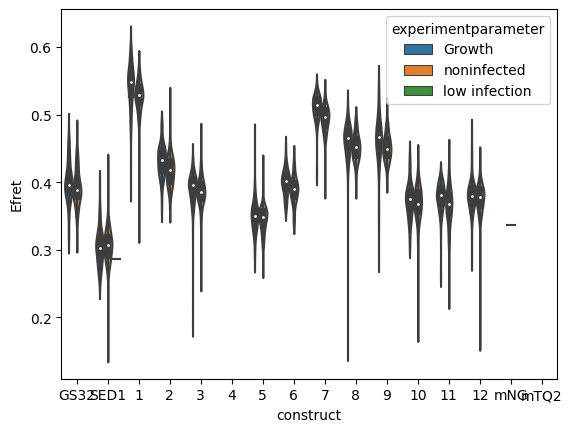

In [27]:


tmp_df = pixels_to_micron(df2)
tmp_df = acceptor_correction(tmp_df)
tmp_df = calculate_efret(tmp_df)
tmp_df = area_cutoffs(tmp_df)
tmp_df = remove_maximums(tmp_df, 'directAcceptor')
tmp_df = remove_minimums(tmp_df, 'directAcceptor')
tmp_df = directacceptor_mean_cutoffs(tmp_df)
tmp_df = donor_mean_cutoffs(tmp_df)
tmp_df = infection_false_positives(tmp_df)
tmp_df = infection_parameters(tmp_df)



construct_order = ['GS32', 'SED1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
experiment_order = ['Infection']
experiment_condition = ['Growth', 'Infection']
experiment_parameter = ['noninfected', 'infected']

my_sort_dict = {
            'construct' : construct_order,
            'experiment': experiment_order,
            'experimentcondition': experiment_condition,
            'experimentparameter': experiment_parameter, 
               }




tmp_df = set_categorical_order(tmp_df, column_name='construct', category_order= construct_order)


growth_df = tmp_df.loc[tmp_df['experimentcondition'] == 'Growth']
noninfected_only = growth_df.loc[growth_df['experimentparameter'] == 'noninfected']
noninfected_only['experimentparameter'] = 'Growth'


this_df = tmp_df.loc[tmp_df['experimentcondition'] == 'Infection']

test_df = pd.concat([noninfected_only, this_df])

test_df  = test_df .loc[test_df ['timepoint']=='0']
#test_df  = test_df .loc[test_df['construct']=='1']
sns.violinplot(test_df, x='construct', y='Efret', hue='experimentparameter')



In [26]:
df2

,label,area,donor_intensity_mean,donor_intensity_min,donor_intensity_max,donor_intensity_std,acceptor_intensity_mean,acceptor_intensity_min,acceptor_intensity_max,acceptor_intensity_std,...,construct,experiment,experimentcondition,replicate,passages,exposurecam1,cyanled,exposurecam2,blueled,greenled
0,1,2953.0,6647.837402,2087.0,10984.0,1906.072754,9388.821289,5526.832031,14527.038086,2165.582520,...,9,Infection,Infection,1,21,25,12u5,25,12u5,6u5
1,2,4245.0,4230.544922,950.0,9734.0,1423.404297,4854.447266,307.898529,10329.111328,1843.824097,...,9,Infection,Infection,1,21,25,12u5,25,12u5,6u5
2,3,153.0,1241.732056,697.0,2043.0,291.369934,919.417603,373.976166,2014.572144,388.826813,...,9,Infection,Infection,1,21,25,12u5,25,12u5,6u5
3,4,10625.0,2596.640869,214.0,4867.0,1288.427002,3717.738525,415.568054,6830.301270,1837.979370,...,9,Infection,Infection,1,21,25,12u5,25,12u5,6u5
4,5,9630.0,868.782349,293.0,1413.0,215.324570,1248.128174,337.957672,1982.171387,317.290100,...,9,Infection,Infection,1,21,25,12u5,25,12u5,6u5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123671,74,3126.0,2258.308105,1121.0,4882.0,730.349670,1309.568115,0.000000,3248.113525,347.391846,...,mTQ2,Infection,Growth,3,25,25,12u5,25,12u5,6u5
123672,75,5691.0,7330.384766,1616.0,10606.0,1667.831543,3712.254395,0.000000,5502.651855,1241.664551,...,mTQ2,Infection,Growth,3,25,25,12u5,25,12u5,6u5
123673,76,2052.0,4273.045410,1334.0,10130.0,2189.566895,2183.445801,0.000000,5171.686523,1375.748169,...,mTQ2,Infection,Growth,3,25,25,12u5,25,12u5,6u5
123674,77,2575.0,4389.634766,1365.0,9452.0,1767.066895,2585.014893,0.000000,5441.430664,1184.838867,...,mTQ2,Infection,Growth,3,25,25,12u5,25,12u5,6u5


In [ ]:
img= img.transpose('t', 'ch', 'row', 'col' )
java_img = ij.py.to_java(img)
java_img.shape


In [25]:
ij.IJ.save(java_img, r'E:\test.tif')

In [7]:
img =ij.io().open(r'E:\Patrick\Infection\New_parameters\20250207_infection_save\Tif\aligned_images\date-20250209_techReplicate-1_well-E4_construct-5_experiment-Infection_experimentcondition-Infect_replicate-1_passages-19_exposurecam1-25_cyanled-12u5_exposurecam2-25_blueled-12u5_greenled-6u5.tif')
print(img.shape)
img = ij.py.from_java(img)
print(img.sizes)

(2048, 2048, 4, 9)
Frozen({'t': 9, 'row': 2048, 'col': 2048, 'ch': 4})


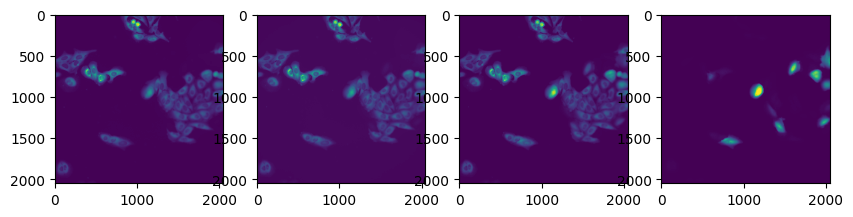

In [8]:
tmp_img = img.isel(t=0)
fig, ax = plt.subplots(1, 4, figsize=(10,10))
for i in range(img.sizes['ch']):
    ax[i].imshow(img.isel(ch=i, t=6))
    

In [ ]:
class DataCleaner:
    def __init__(self, df):
        self.dataframe = df
        self.cleaned_df = 
        
        self.plotting_Storage = PlottingStorage()
        self.plotting_storage.experiment_dict = self.__get_unique_experiments()
        self.plotting_storage.timepoint_dict  = self.__get_timepoints() 

    
    def __get_unique_experiments(self)-> dict:
        unique_experiments = self.dataframe.experiment.unique()
        return {index: unique_experiment[index] for index in range(len(unique_experiment))}

    def __get_unique_experiment_time(self, experiment)-> dict:
        tmp_df = self.dataframe.loc[self.dataframe['experiment'] == experiment]
        unique_timepoint = tmp_df.timepoint.unique()
        return {index: unique_experiment[index] for index in range(len(unique_timepoint))}

    def __get_timepoints(self):
        return {self.plotting_storage.experiment_dict[index]: self.__get_unique_experiment_time(self.plotting_storage.experiment_dict[index]) for index in range(len(self.plotting_storage.experiment_dict[index]))}

    def __get_(self):

    def __clean_df(self):
        

In [15]:
my_list = ['this-I', 'that-II', 'here-III', ]

my_dict = {x.split('-')[0]: x.split('-')[1] for x in my_list if '-' in x}

this = my_dict['this']
print(this.lower())

i
